In [1]:
import os
import sys
import time
import serial
import serial.tools.list_ports
import datetime #as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit
import math

from scipy.stats import shapiro
from scipy.stats import f_oneway
from scipy import signal
from scipy.stats import alexandergovern
from scipy.stats import kruskal
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from scipy.stats import lognorm
from scipy.stats import f as fSnedecora
import statistics

In [2]:
'''Wskazanie miejsca zapisu próbek, nazw plików csv i numerów grup'''
#dir of logs
dir='D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/'
numberOfGroup=[1,2,3,4]

force='ID00_CH00_WeightScale2kN.csv' #name of file with force data
volt='ID01_CH00_Analog1.csv' #name of file with voltage data

global dir_img #dir for saving image of plots etc....
dir_img='D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/img/' 


In [3]:
class ChangeDataNames:
    '''
    class responsible for renaming columns and data format
    for 2 dataframe: 
    'Mass [g]': 'Force' and 'Voltage [mV]': 'Voltage'
    
    using Sawwicki Golaya filter for to eliminate measurement disturbances (saw signal)
    '''
    
    def __init__(self,df_force,df_volt):
        self.df_force=df_force
        self.df_volt=df_volt
        
    def correctDataAndName(self,area):

        self.df_force=self.df_force.rename(columns={'Mass [g]': 'Force', "time [ms]": 'timeF'})
        self.df_volt=self.df_volt.rename(columns={'Voltage [mV]': 'Voltage', "time [ms]": 'timeV'})
        
        
        self.df_force.Force=self.df_force.Force*0.0098105 
        
        
        '''Sawicki Golaya'''
        #self.df_force.Force=Calculus.averagingFilter(self.df_force.Force,3)
        window_length=5
        polyorder=2 #less then window
        self.df_force.Force=signal.savgol_filter(self.df_force.Force, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        
        self.df_force.timeF=self.df_force.timeF/1000
        self.df_volt.timeV=self.df_volt.timeV/1000
        self.df_force['Stress']=self.df_force.Force/area
        #self.df_volt.Voltage=self.df_volt.Voltage/10

            

        self.df_force.Force=self.df_force.Force-self.df_force.Force.iloc[0]
            #df2[dfForceName]=df2[dfForceName].ewm(com = 0.4).mean()
        self.df_force.reset_index(drop=True) 
        self.df_volt.reset_index(drop=True)

        dfnew=pd.concat([self.df_volt, self.df_force.reindex(self.df_volt.index)], axis=1)
        
        return dfnew
    
    
    
class SubData:
    '''
    class preparing artificial set of data
    
    in this case set 
    '''
    def __init__(self):
        pass
    @staticmethod    
    def shortExtensions(R):
        sExtensions=pd.DataFrame({ 'A' : range(0,R,1)})
        #czas rozciagania to 3sekundy i próbkowanie = 20sample/s stąd 60
        sExtensions=sExtensions['A']
        sExtensions=sExtensions/10/100
        return sExtensions

class CutterDF(SubData):
    '''
    class with methods to extrcat specific part of data from the entire waveform 
    '''
    def __init__(self,df):
        self.df=df
        
    def idOfMaxStress(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        maxIdForce=[(self.df.loc[stressRanges[i*2]:stressRanges[i*2+1], 'Stress'].idxmax()) 
                    for i in range (int(len(stressRanges)/2))]   
        return maxIdForce
    
    def cutPartOfRange(self,*stressRanges):
        if len(stressRanges)%2!=0:
            print('Musi być parzysta ilość argumentów dla definicji przedziałów')
        else:
            pass
        #dfshort=self.df.Stress[maxIdForce1-60:maxIdForce1].reset_index(drop=True)
        
        dfshort=[(self.df.Stress[stressRanges[i*2]:stressRanges[i*2+1]].reset_index(drop=True)) 
                 for i in range (int(len(stressRanges)/2))] 

            
        
        #dfshort=dfshort.iloc[::-1]
        return dfshort            

    
class Calculus(SubData):
    
    '''
    class with methods for mathematical calculation
    
    1. calculates a straight line which is to be 
    an approximation of the course and its coefficient 
    a from the formula y = ax + b corresponds to the elasticity modulus
    
    2. averaging filter
    
    3. calculates deriattive of wavefrom
    
    '''
    def __init__(self):   
        pass

    
    @staticmethod    
    def funcYoung(e,a,b): #współczynnik szybkości relaksacji
        return a*e+b
    @staticmethod    
    def youngFunc(e,s):
    

        #print(e.head(-5))
        #print(s.head(-5))
        plt.figure(figsize=(7,3))

        plt.plot(e,s)
        popt, _ = curve_fit(Calculus.funcYoung, e, s, method='lm')
        a, b=popt
        #print(popt)

        plt.plot(e,s)
        plt.plot(e, Calculus.funcYoung(e, *popt), 'g--') #funkcja pokazująca dopasowane expFunc do rzeczywistej
        #plt.legend()
        plt.show()
        return a
    @staticmethod
    def averagingFilter(interval, window_size):
        window = np.ones(int(window_size))/float(window_size)
        return np.convolve(interval, window, 'same') 
    
    '''Check diffrent methods for deriattive'''
    @staticmethod
    def deriattiveDf(x,y):
        d=np.zeros(len(x))
        for i in range(1,len(x)-1):
            d[i]=((x[i+1]-x[i-1])/(y[i+1]-y[i-1]))
            d[0]=d[1]
            
        return d

        
class Ploting(Calculus):
    '''
    class with methods for plottig
    
    1. plotting for histeresis
    2. plotng for boxplot
    
    '''
    def __init__(self):
        pass
    
    def plot_histeresis(self,stress_1,stress_2,xlabel,ylabel,title,label_1,label_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        stress_2=stress_2.iloc[::-1] #odwrócenie drugiego przebiegu

        plt.figure(figsize=(8,5))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.plot(extension,stress_1, label=label_1)
        plt.plot(extension,stress_2, label=label_2)
        plt.fill_between(extension, stress_1, stress_2, color='b', alpha=0.2, hatch='/')
        plt.legend()
        plt.show()  
        pass
    def plot_boxScatterdf(self,df,name_1,ylabel,title,ylim_1=0,ylim_2=300):
        noG=df.columns
        name=''.join(noG)
        name=name+'_'+name_1+'_boxplot'
        plt.figure()
        df.boxplot()
        for i, d in enumerate(df):
            y = df[d]
            x = np.random.normal(i + 1, 0.04, len(y))
            plt.scatter(x, y)
        #plt.ylim(10,70)
        plt.ylim(ylim_1,ylim_2)
        plt.title(title)
        plt.ylabel(ylabel)
        plt.savefig(dir_img+name+'.pdf', dpi=300)
        plt.show()
    
class StaticCalculus(SubData):
    def __init__(self):   
        pass    
    '''
    class with methods for mathematical calculation for statistic
    
    Annov + Test Studenta (tTest)
    
    '''

    @staticmethod    
    def normalDis(df):
        #listoflists=[]
        for col in df.columns:
            l=dfY[col].tolist()
            stats, p = shapiro(l)
            print(col,stats,p)
            #print(col)
            if p > 0.05:
                print ("Rozkład wygląda na normalny")
            else:
                print('Nienormalny')
            sns.distplot(l)
            #fig, ax = plt.subplots(1, 1)
            #shape, location, scale = stats.lognorm.fit(l)
            #mu, sigma = np.log(scale), shape
            plt.show()
            #listoflists.append(l)
            #print(listoflists[0])

    @staticmethod    
    def annovaTest(df,name_1):
        G=[]         
        for i in list(df.columns):
            g = [x for x in df[i].tolist() if str(x) != 'nan']
            G.append(g)
            #print(G)
        MSTR=0
        MSE=0

        meanG=0
        n=0
        for i in range(len(G)):
            n=n+len(G[i])
            meanG=meanG+sum(G[i])
        meanG=meanG/n
        #print(meanG)

        for i in range(len(G)):
            #print(i)
            meanGi=statistics.mean(G[i])
            SSbetween_group=len(G[i])*(meanGi-meanG)**2
            MSTR=MSTR+SSbetween_group
            #print(meanGi)
            for j in range(len(G[i])):
                SSwithin_group=(G[i][j]-meanGi)**2
                MSE=MSE+SSwithin_group


                #print(j)

        MSTR=MSTR*(1/(len(G)-1))        
        MSE=MSE*(1/(n-len(G)))
        F=MSTR/MSE

        p=fSnedecora.sf(F, len(G)-1, n-len(G)) # F Snedecora 
        #lewo i prawo brzeżnie

        #s,p=f_oneway(G[0],G[1],G[2],G[3])
        #print('pvalue = '+str(p)+'\n')
        print('pvalue = '+str(p)+' F='+str(F)+'\n')
        if p<0.05:
            print('p<0.05\n')
            StaticCalculus.postHocTest(df,name_1)

    @staticmethod    
    def postHocTest(df,name_1):
        x=[]
        j=0
        k=0
        #print(df.stack())
        noG=df.columns
        df.columns.name = 'var_name'
        name=''.join(noG)
        name=name+'_'+name_1+'_TTest'
        #x=df.stack()
        #x.name = 'val'
        #x.reset_index()
        #x.rename(columns={[0]: 'groups', [1]: 'val'}, inplace=True)
        x=pd.melt(df.reset_index(), value_vars=noG, var_name='var_name', value_name='value')
        x.dropna(subset = ["value"], inplace=True)
        #print(x)
        '''
        for i in list(df.columns):

            g = [x for x in df[i].tolist() if str(x) != 'nan']
            x.append(g)
            k=k+j # poprawka Bonferroniego https://pl.wikipedia.org/wiki/Poprawka_Bonferroniego
            j=j+1 # Bonferroniego
            #print(k)
        '''
        
        print('Anderson bez poprawki Bonferroniego')
        print(sp.posthoc_anderson(x,val_col='value', group_col='var_name'))
        print('Ttest bez poprawki Bonferroniego')
        
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name'))
        print('Ttest z poprawką Bonferroniego')
        print(sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni'))
        #print(k)
        plt.figure()
        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
        pc=sp.posthoc_ttest(x,val_col='value', group_col='var_name',p_adjust='bonferroni')  # *k - Bonferroniego
        sp.sign_plot(pc, **heatmap_args)
        plt.savefig(dir_img+name+'.pdf', dpi=300)
        plt.show()

class Parameters(Calculus,SubData):
    '''
    Main class
    with set od methods to return:
    
    young - elastic modulus
    
    dropOfStress -  the value of stress of subtract difference between:
                    first peak, and point od end of relaxation
    
    areaOfHisteresis - area of histeresis
    
    dropOfElasticModulus - drof of elastic modulus between first and second extension: 
                           dropOfYoung=((young1 - young2)/young1)*100[%]
                           
    voltMax - return max voltage value
    
    inflectionPoint - to calculating point of inflection
    
    '''
    def __init__(self,df):
        self.df=df
        
    def young(self,shortStress,rangeOfStraight):

        shortStress=shortStress[-rangeOfStraight:]    
        extension=SubData.shortExtensions(rangeOfStraight)
        modulYounga=Calculus.youngFunc(extension,shortStress)
        return modulYounga
        
    def dropOfStress(self,maxIdForce,endRel):

        dropStress=((self.df.Stress.iloc[maxIdForce]-self.df.Stress.iloc[endRel])/self.df.Stress.iloc[maxIdForce]*100)
        
        return dropStress
    
    def areaOfHisteresis(self,stress_1,stress_2):
        extension=SubData.shortExtensions(len(stress_1.to_numpy()))
        
        area1=np.trapz(stress_1.to_numpy(), x=extension.to_numpy())
        area2=np.trapz(stress_2.to_numpy(), x=extension.to_numpy())
        histeresis=(area1-area2)/area1
        #area1-area2 - strata energii
        #area1 - energia całkowita
        return histeresis
    
    def dropOfElasticModulus(self,young1,young2):
        dropOfYoung=((young1 - young2)/young1)*100
        return dropOfYoung
    
    def voltMax(self,z1,z2):
        maxVolt = self.df.Voltage.loc[int(z1):int(z2)].max()
        return maxVolt

    def inflectionPoint(self,stress,rangeOfStraight):
        stress=stress[-rangeOfStraight:]
        extension=SubData.shortExtensions(rangeOfStraight)
        
        window_length=31#rangeOfStraight-29
        polyorder=7 #less then window #1
        plt.plot(stress)
        stress=signal.savgol_filter(stress, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
        
        ds_1=Calculus.deriattiveDf(extension,stress)
        window_length=7
        polyorder=1 #less then window        
        #ds_1=signal.savgol_filter(ds_1, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        
        #ds_2=Calculus.deriattiveDf(extension[:-1],ds_1)
        #window_length=7
        #polyorder=1#less then window        
        #ds_2=signal.savgol_filter(ds_2, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

        #dff=Calculus.deriattiveDf(extension,Calculus.deriattiveDf(extension,stress))
        '''
        plt.plot(stress)
        plt.show()

        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        #plt.plot(ds_2)
        #plt.show()
        #'''
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.012)
        
        
        '''
        Znajdz mediane dla przebiegu ostatnich 5-10 punktow jakos i wyzeruj 
        wzglem niej  a potem warunek jak na górze
        
                
        most_common = max(list(ds_1[-10:-1]), key = list(ds_1).count)
        print(most_common)
        ds_1=ds_1-most_common
        p=rangeOfStraight-next(x[0] for x in enumerate(ds_1[::-1]) if x[1] > 0.05)
        plt.plot(ds_1)
        plt.ylim(0,0.1)
        plt.grid()
        plt.show()
        
        '''
        #print(60-p)
        return p

[467, 12631, 12451]


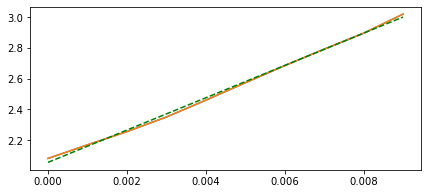

105.12316796656123


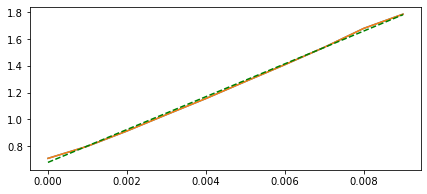

122.54348485477261


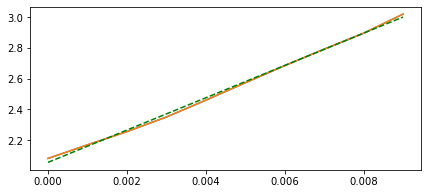

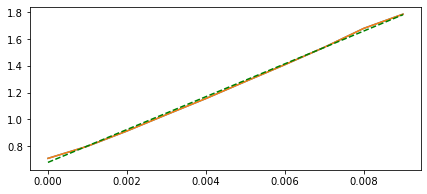

-16.571339339538017
0.7948870626291014
nan
0.6847017734582549
55.70919248472722
47
50


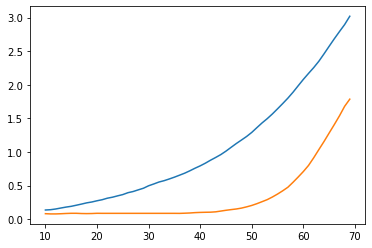

In [4]:
df0= pd.read_csv ('g1.csv')
strGroup='1'

newDir=dir+'G102/'
try:
    dfarea=df0['g102.STL'].nsmallest(50)
except:
    dfarea=df0['G102.STL'].nsmallest(50)
#try:
#    dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
#except:
#   dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
area=dfarea.mean()

df2 = pd.read_csv (newDir+force, delimiter=';',decimal=',')
df3 = pd.read_csv (newDir+volt, delimiter=';',decimal=',')  

a=ChangeDataNames(df2,df3)
b=a.correctDataAndName(area)
    
#print(b)

c=CutterDF(b)

d=c.idOfMaxStress(0,4000,12500,14000)
#                 first peak,second peak, end of first relaxation
d=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
print(d)
#print(e)
e=d
print(c)
            #afe=dfnew[dfStressName][maxIdForce1-60:maxIdForce1].reset_index(drop=True)
            #afr=dfnew[dfStressName][end_fisrtRel:end_fisrtRel+60].reset_index(drop=True)
            #ase=dfnew[dfStressName][maxIdForce2-60:maxIdForce2].reset_index(drop=True)
            #asr=dfnew[dfStressName][maxIdForce2+60:maxIdForce2+120].reset_index(drop=True)
f=c.cutPartOfRange(e[0]-70,e[0],e[2],e[2]+70,e[1]-70,e[1],e[1]+70,e[1]+140)
#print(f)
h=Calculus()


#plot_histeresis(stress_1,stress_2,extension,xlabel,ylabel,title,label_1,label_2)


l=Parameters(b)

print(l.young(f[0],10))
print(l.young(f[2],10))
print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

print(l.areaOfHisteresis(f[0],f[1]))
print(l.areaOfHisteresis(f[2],f[3]))
print(l.areaOfHisteresis(f[0],f[2]))
print(l.dropOfStress(e[0],e[2]))



print(l.inflectionPoint(f[0],60))
print(l.inflectionPoint(f[2],60))

In [5]:
def dataProcessing(numGroup):
    df0= pd.read_csv ('g'+str(numGroup)+'.csv')
   
    dfG= pd.DataFrame({'A' : []})
    
    for i in range(1,13):
        strGroup='G'+str(numGroup)+str(i).zfill(2)
        newDir=dir+strGroup+'/'
        print(newDir)

        try:
            try:
                dfarea=df0['g'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
            except:
                dfarea=df0['G'+str(numGroup)+str(i).zfill(2)+'.STL'].nsmallest(50)
            area=dfarea.mean()
            dfForce = pd.read_csv (newDir+force, delimiter=';',decimal=',')
            dfVolt = pd.read_csv (newDir+volt, delimiter=';',decimal=',') 

        
            changedata=ChangeDataNames(dfForce,dfVolt)
            
            cutedf=CutterDF(changedata.correctDataAndName(area))
            imaxs=cutedf.idOfMaxStress(0,4000,12500,15000)
            #first peak,second peak, end of first relaxation
            #e=c.idOfMaxStress(0,4000,12500,15000,d[0]+11985 -5,d[0]+11985 +10)
            #e=c.idOfMaxStress(0,4000,12500,15000,d[1]-200 ,d[1]-60)
            imaxs.append(imaxs[1]-180)
            print(imaxs)
            f=cutedf.cutPartOfRange(imaxs[0]-70,imaxs[0],imaxs[2],imaxs[2]+70,imaxs[1]-70,imaxs[1],imaxs[1]+70,imaxs[1]+140)

            parameters=Parameters(changedata.correctDataAndName(area))

            #print(l.young(f[0],10))
            #print(l.young(f[2],10))
            #print(l.dropOfElasticModulus(l.young(f[0],10),l.young(f[2],10)))

            #print(l.areaOfHisteresis(f[0],f[1]))
            #print(l.areaOfHisteresis(f[2],f[3]))
            #print(l.areaOfHisteresis(f[0],f[2]))

            inflPoint_1=parameters.inflectionPoint(f[0],60)
            inflPoint_2=parameters.inflectionPoint(f[2],60)#parameters.young(f[0],10),
            if inflPoint_1 >50:
                inflPoint_1=50
            if inflPoint_2 >50:
                inflPoint_2=50
            listOfParameters=[parameters.young(f[0],60-inflPoint_1),parameters.young(f[2],60-inflPoint_2),parameters.areaOfHisteresis(f[0],f[1]),
                              parameters.areaOfHisteresis(f[2],f[3]),parameters.areaOfHisteresis(f[0],f[2]),
                              parameters.dropOfStress(imaxs[0],imaxs[2])]
            
            
            listOfParameters.append((listOfParameters[1]/listOfParameters[0])*100)
            listOfParameters.append(inflPoint_1)
            listOfParameters.append(inflPoint_2)
            listOfParameters.append(inflPoint_1/inflPoint_2*100)

            #dfPara = pd.DataFrame(listOfParameters)
            dfPara = pd.DataFrame(listOfParameters, columns=[strGroup])
            print(dfPara)
            dfG=pd.concat([dfPara, dfG.reindex(dfG.index)],axis=1)
            



            j=Ploting()
            j.plot_histeresis(f[0],f[2],'Strain','Stress [MPa]','Histeresis between first and second extension '+strGroup,"first peak","second peak")
            j.plot_histeresis(f[0],f[1],'Strain','Stress [MPa]','Histeresis between first extension and relief  '+strGroup,"extension","relief")
            #j.plot_histeresis(f[2],f[3],'Strain','Stress [MPa]','Histeresis between second extension and relief '+strGroup,"extension","relief")
        except:
            print(f'próbka: {strGroup}  jest uszkodzona/odrzucona etc...')
    
    dfG.drop('A', inplace=True, axis=1)
    return dfG.T

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G101/
[592, 12755, 12575]


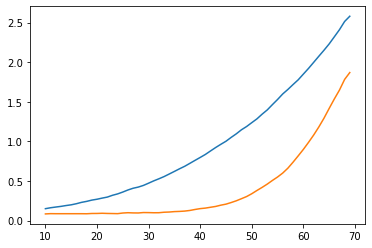

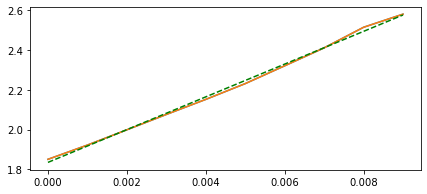

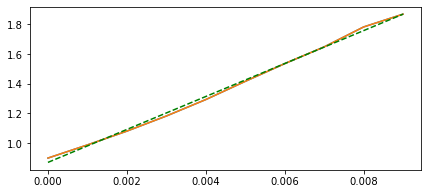

         G101
0   82.446558
1  111.051566
2    0.706842
3         NaN
4    0.589200
5   39.448713
6  134.695213
7   50.000000
8   50.000000
9  100.000000


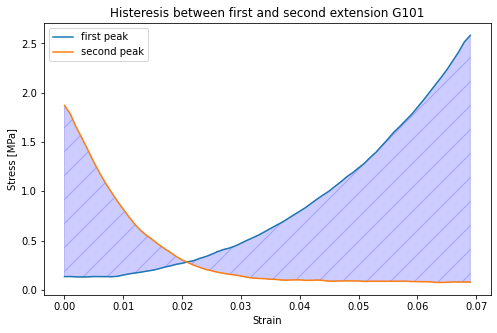

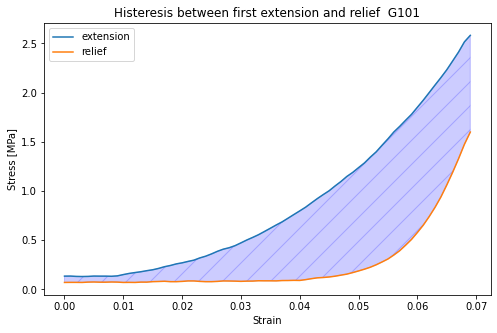

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G102/
[467, 12631, 12451]


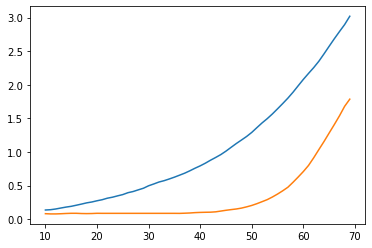

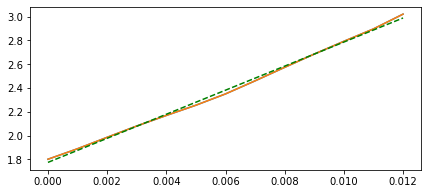

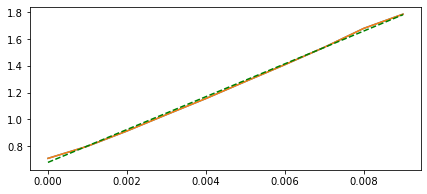

         G102
0  101.060493
1  122.543485
2    0.794887
3         NaN
4    0.684702
5   56.940517
6  121.257558
7   47.000000
8   50.000000
9   94.000000


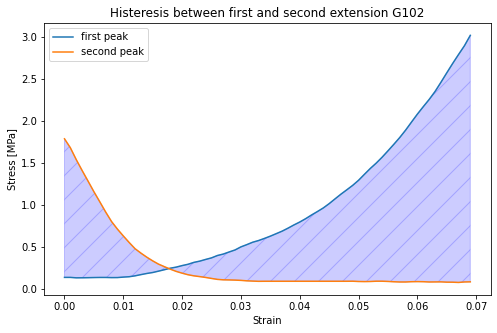

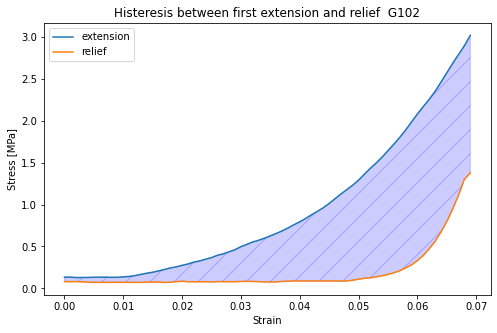

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G103/
[431, 12595, 12415]


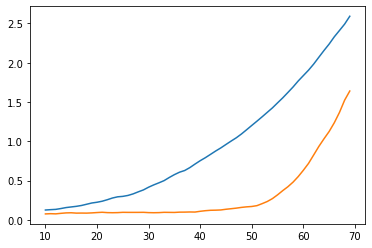

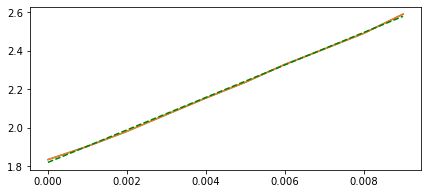

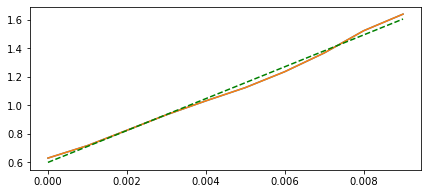

         G103
0   84.244226
1  111.603834
2    0.796784
3         NaN
4    0.675975
5   51.504580
6  132.476537
7   50.000000
8   50.000000
9  100.000000


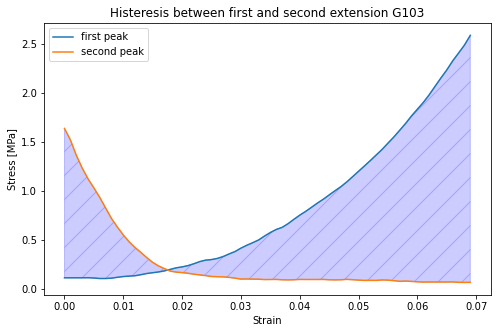

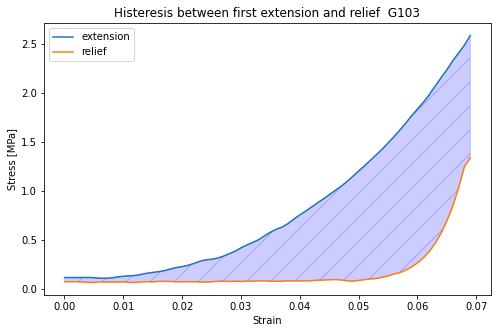

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G104/
próbka: G104  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G105/
próbka: G105  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G106/
[478, 12643, 12463]


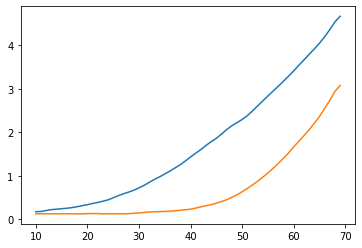

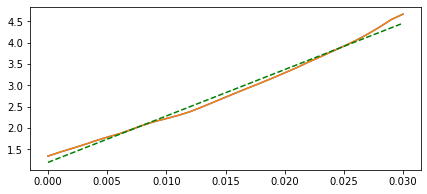

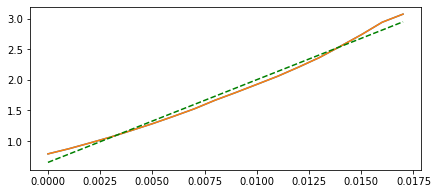

         G106
0  108.652849
1  135.100993
2    0.723611
3         NaN
4    0.597787
5   50.246596
6  124.341879
7   29.000000
8   42.000000
9   69.047619


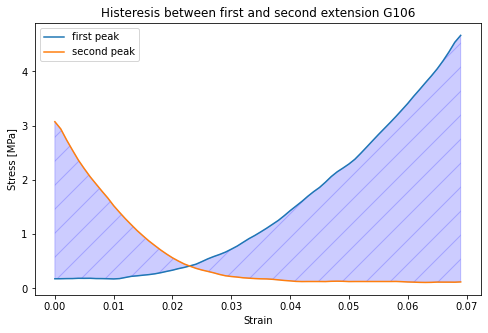

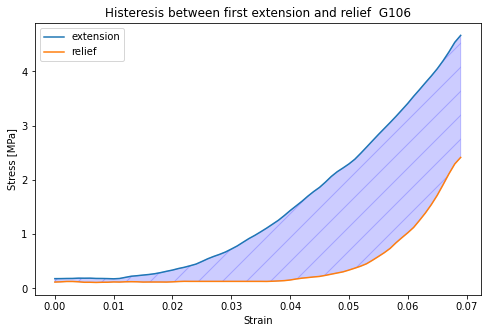

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G107/
próbka: G107  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G108/
[467, 12630, 12450]


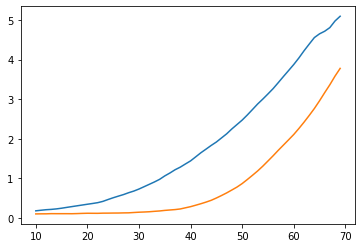

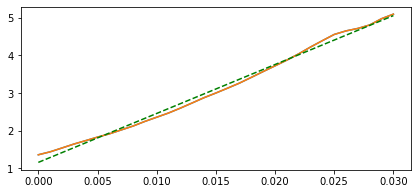

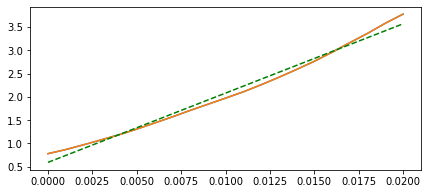

         G108
0  129.739895
1  148.716859
2    0.687571
3         NaN
4    0.541283
5   43.938734
6  114.626930
7   29.000000
8   39.000000
9   74.358974


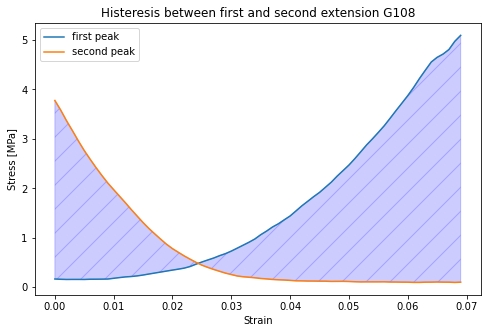

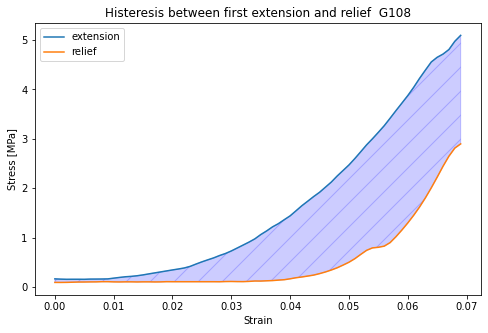

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G109/
[430, 12594, 12414]


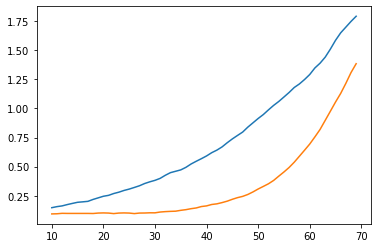

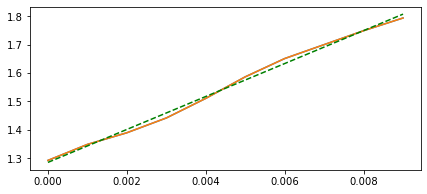

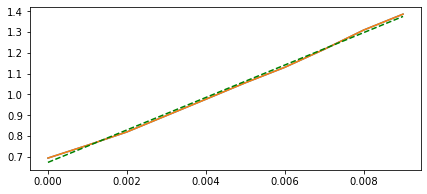

         G109
0   57.979718
1   77.888608
2    0.698249
3         NaN
4    0.534836
5   47.795153
6  134.337680
7   50.000000
8   50.000000
9  100.000000


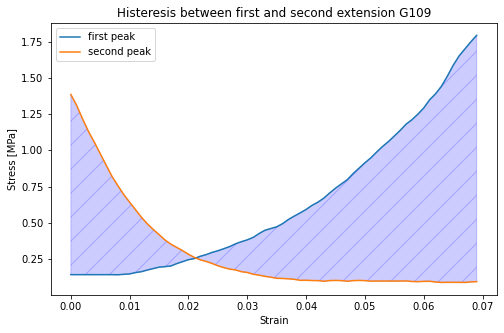

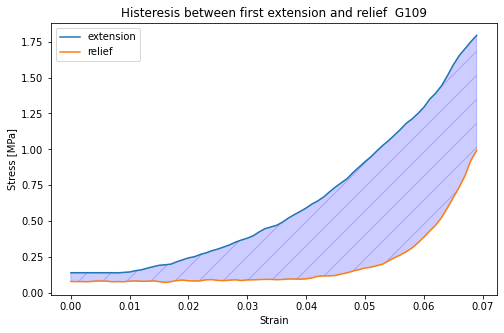

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G110/
[430, 12594, 12414]


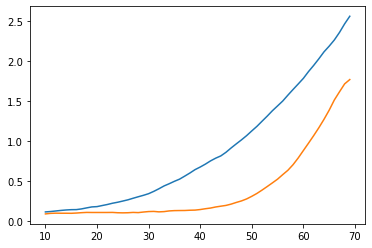

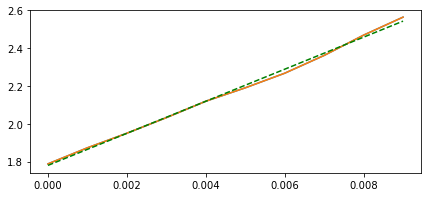

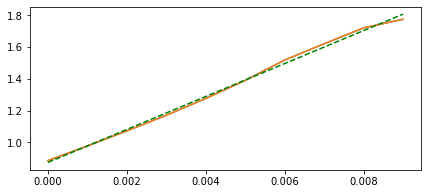

         G110
0   84.818687
1  103.393028
2    0.706741
3         NaN
4    0.545800
5   47.662602
6  121.898879
7   50.000000
8   50.000000
9  100.000000


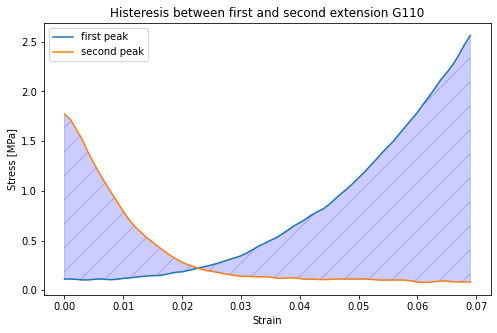

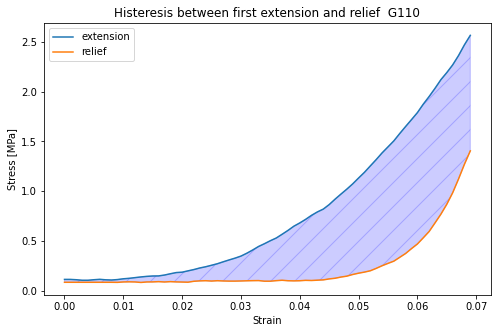

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G111/
[479, 12643, 12463]


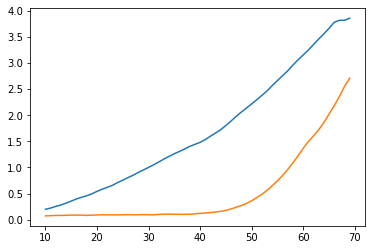

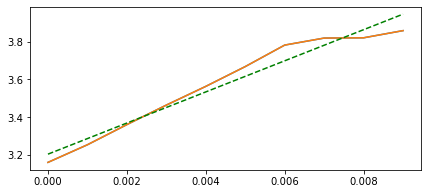

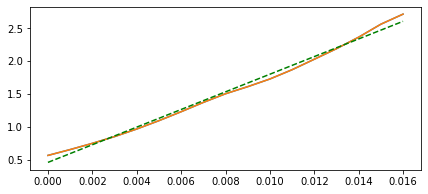

         G111
0   82.691194
1  134.044123
2    0.831603
3         NaN
4    0.695856
5   57.232191
6  162.102054
7   50.000000
8   43.000000
9  116.279070


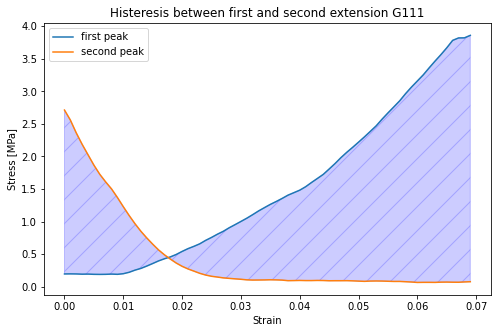

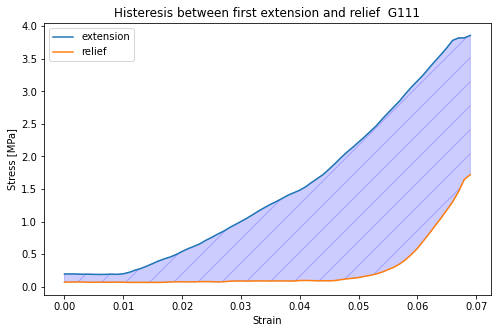

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G112/
[444, 12607, 12427]


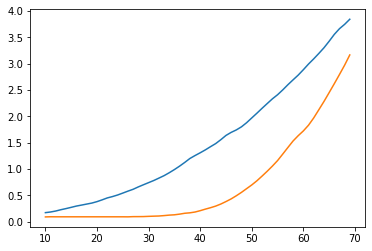

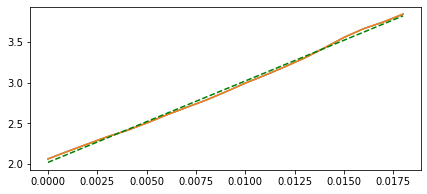

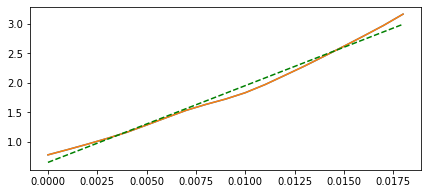

         G112
0  100.181579
1  130.172456
2    0.731312
3         NaN
4    0.540828
5   45.564865
6  129.936520
7   41.000000
8   41.000000
9  100.000000


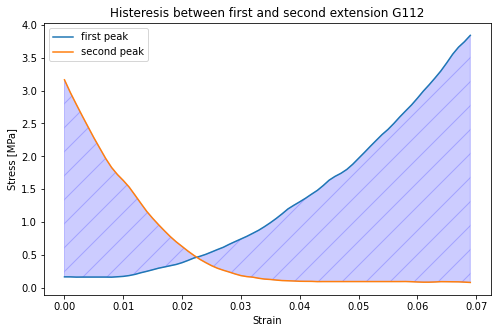

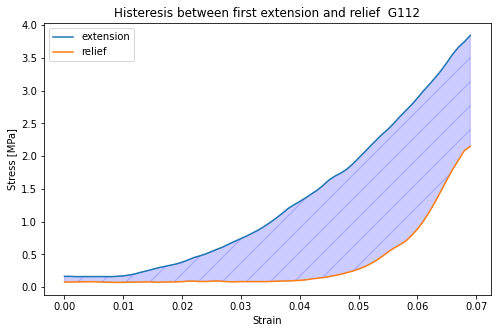

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G201/
[418, 12582, 12402]


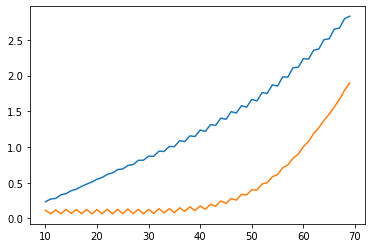

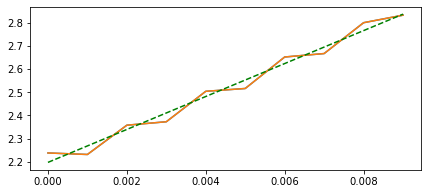

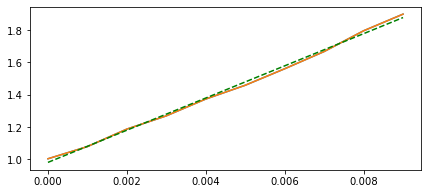

         G201
0   71.013840
1   99.609012
2    0.775347
3         NaN
4    0.677318
5   46.291273
6  140.267042
7   50.000000
8   50.000000
9  100.000000


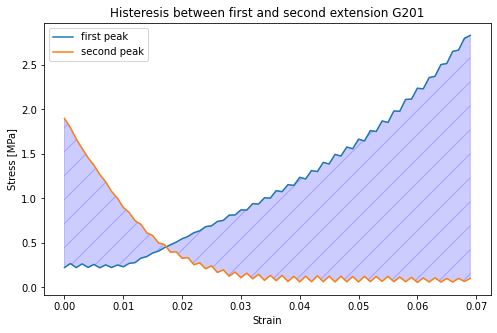

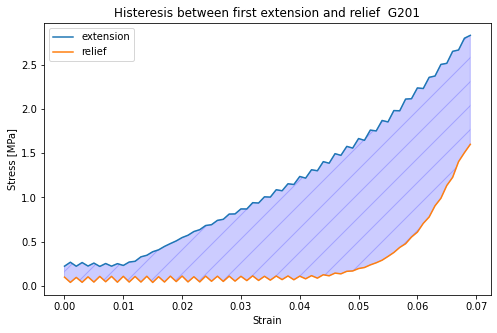

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G202/
próbka: G202  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G203/
próbka: G203  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G204/
próbka: G204  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G205/
[493, 12657, 12477]


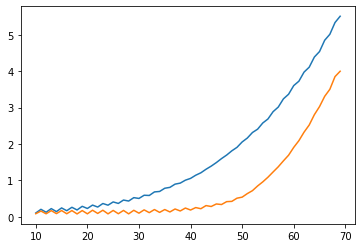

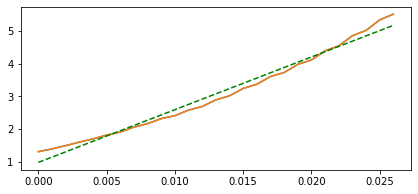

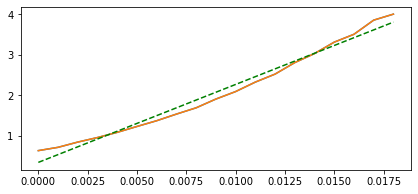

         G205
0  161.161321
1  192.048499
2    0.696773
3         NaN
4    0.525148
5   45.574857
6  119.165379
7   33.000000
8   41.000000
9   80.487805


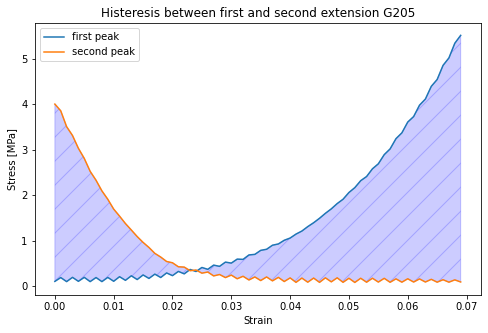

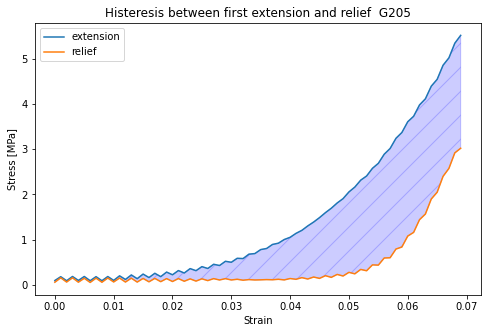

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G206/
[442, 12606, 12426]


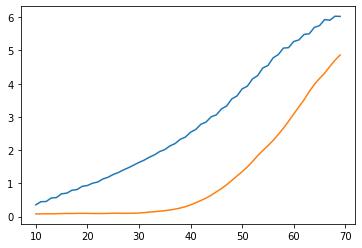

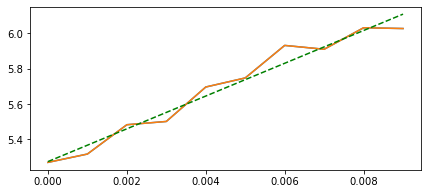

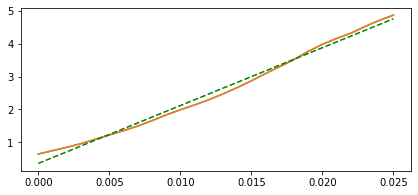

         G206
0   92.513012
1  175.866439
2    0.752183
3         NaN
4    0.590284
5   46.968095
6  190.099139
7   50.000000
8   34.000000
9  147.058824


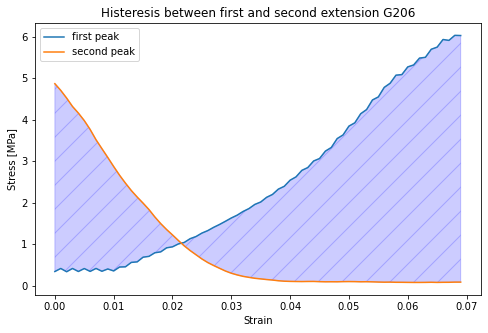

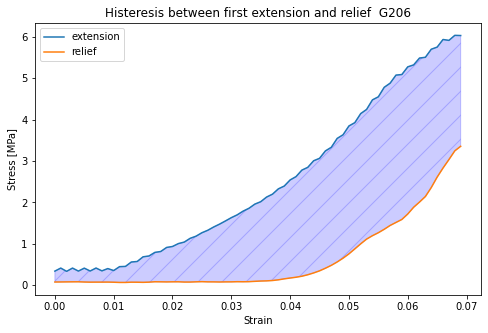

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G207/
[467, 12631, 12451]


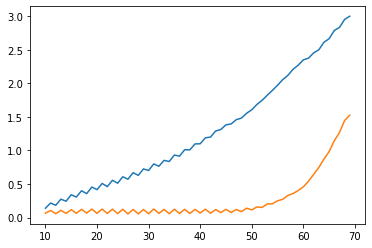

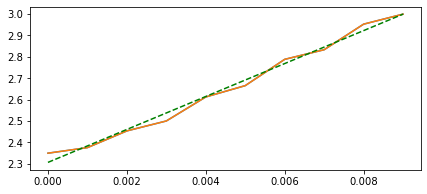

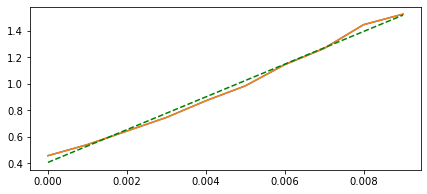

         G207
0   76.983895
1  123.397735
2    0.860917
3         NaN
4    0.793485
5   64.478381
6  160.290324
7   50.000000
8   50.000000
9  100.000000


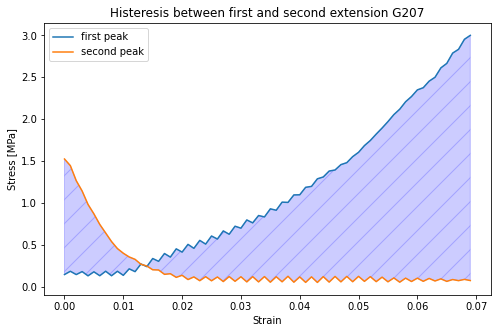

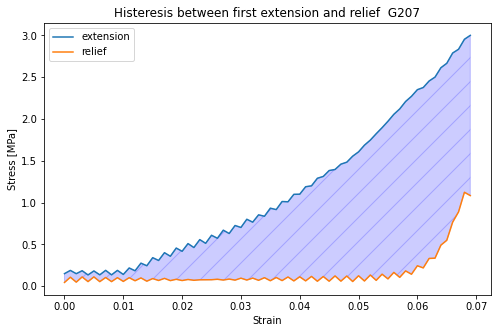

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G208/
[406, 12570, 12390]


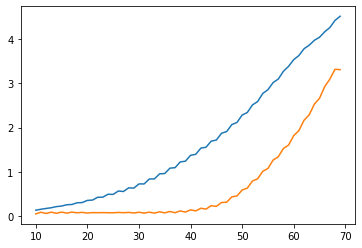

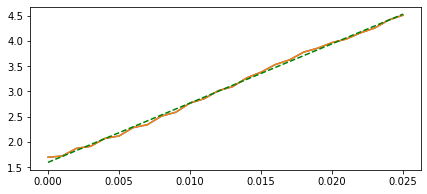

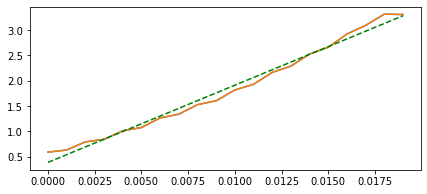

         G208
0  117.468123
1  152.139241
2    0.796572
3         NaN
4    0.596792
5   53.553083
6  129.515342
7   34.000000
8   40.000000
9   85.000000


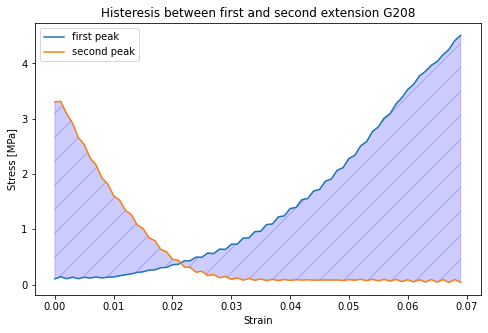

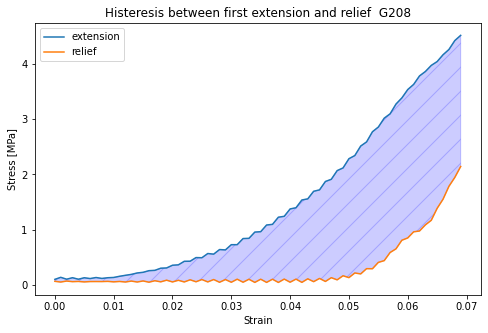

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G209/
[442, 12605, 12425]


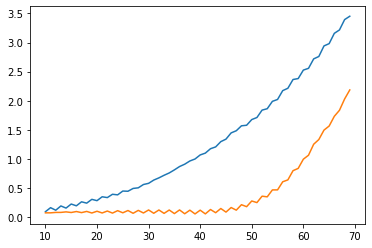

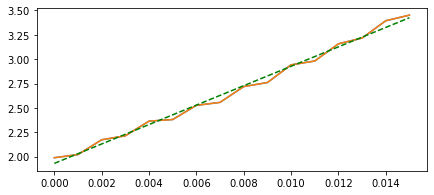

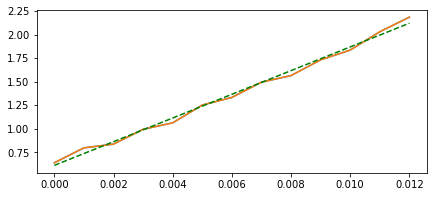

         G209
0   99.593963
1  125.739314
2    0.765054
3         NaN
4    0.685827
5   50.291649
6  126.251944
7   44.000000
8   47.000000
9   93.617021


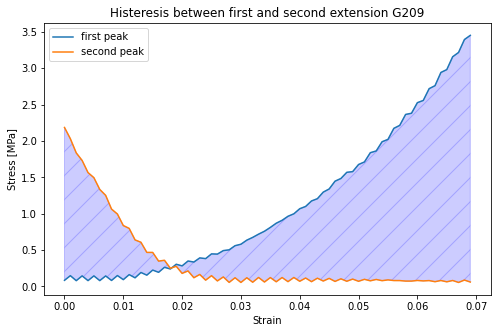

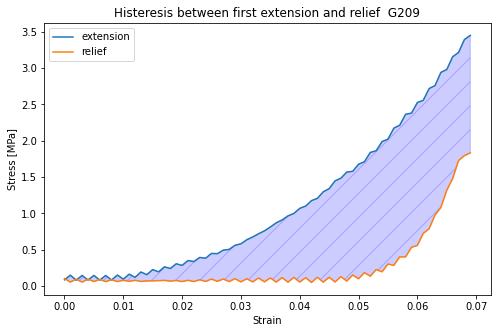

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G210/
[406, 12570, 12390]


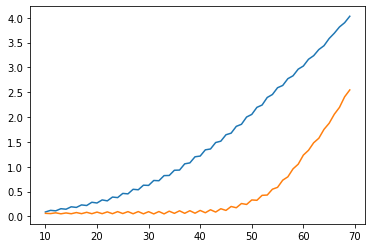

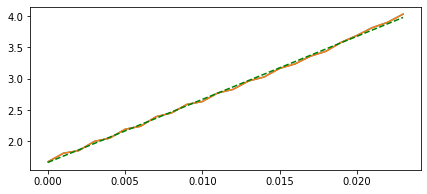

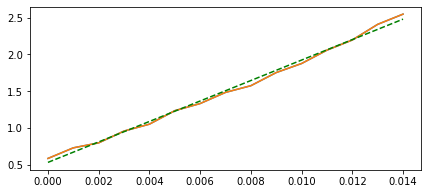

         G210
0  100.468217
1  139.121027
2    0.795820
3         NaN
4    0.693998
5   56.822687
6  138.472674
7   36.000000
8   45.000000
9   80.000000


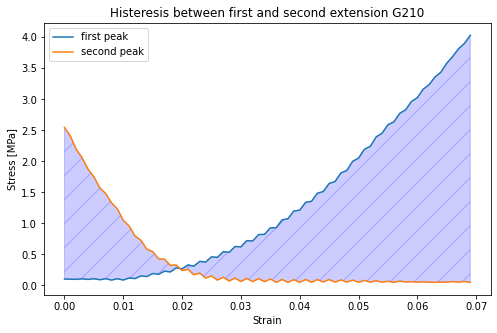

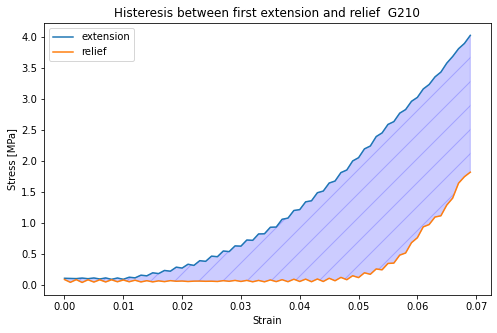

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G211/
[467, 12630, 12450]


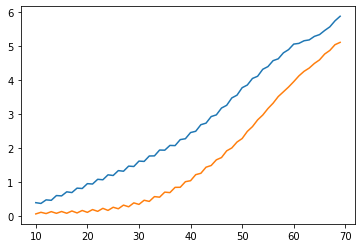

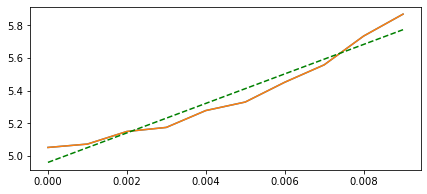

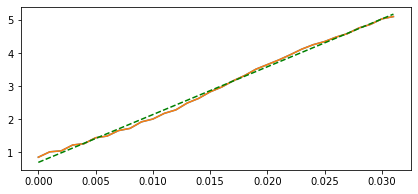

         G211
0   90.305900
1  144.460456
2    0.620874
3         NaN
4    0.388418
5   33.454773
6  159.967904
7   50.000000
8   28.000000
9  178.571429


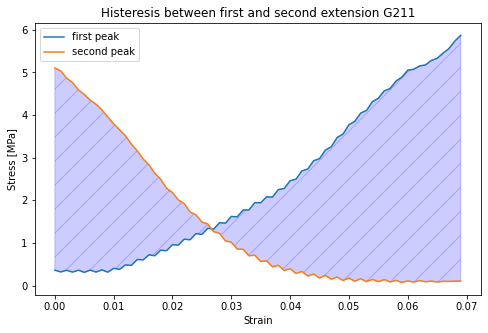

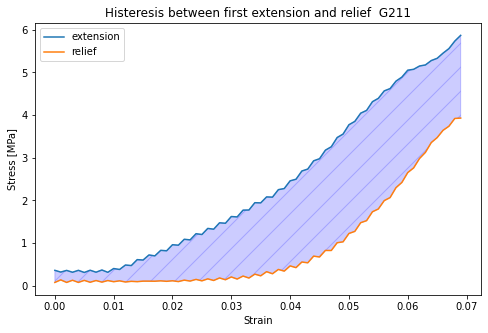

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G212/
[357, 12520, 12340]


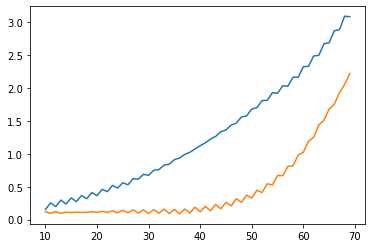

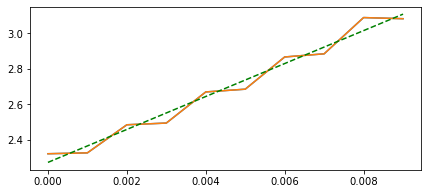

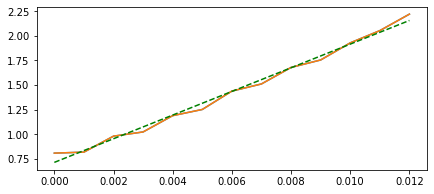

         G212
0   92.628898
1  120.118087
2    0.738879
3    0.636373
4    0.634706
5   46.376854
6  129.676689
7   50.000000
8   47.000000
9  106.382979


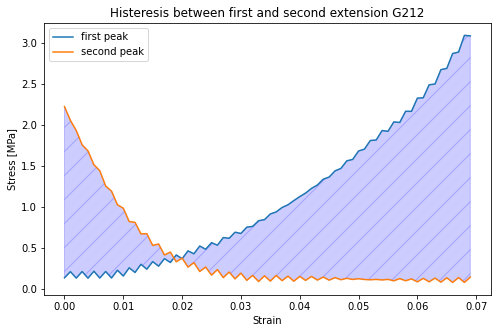

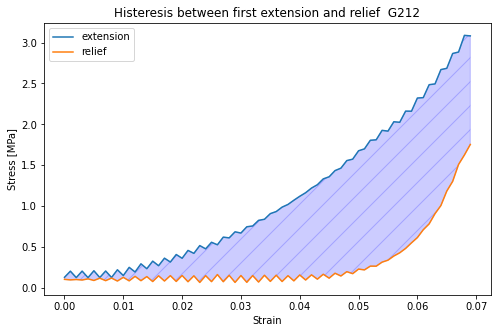

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G301/
[418, 12582, 12402]


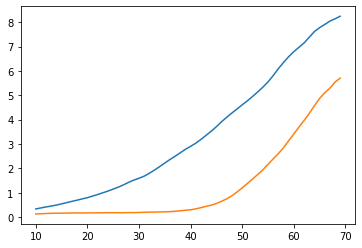

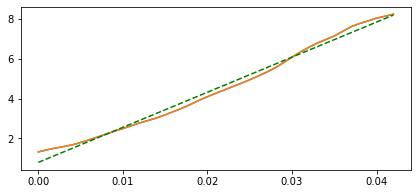

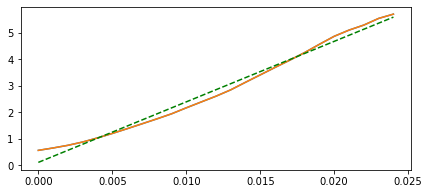

         G301
0  176.103721
1  228.586157
2    0.785724
3         NaN
4    0.623407
5   57.147228
6  129.802003
7   17.000000
8   35.000000
9   48.571429


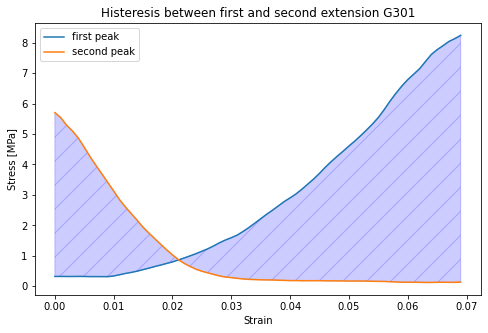

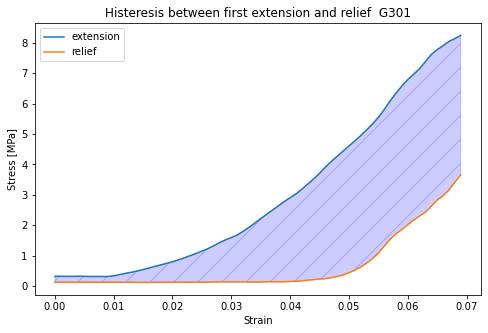

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G302/
[443, 12606, 12426]


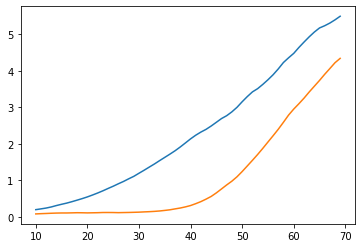

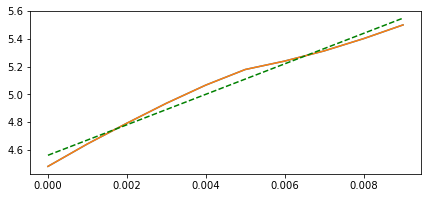

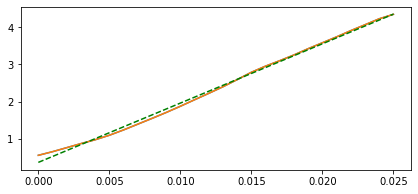

         G302
0  109.727509
1  159.363676
2    0.709762
3         NaN
4    0.532523
5   48.476697
6  145.235846
7   50.000000
8   34.000000
9  147.058824


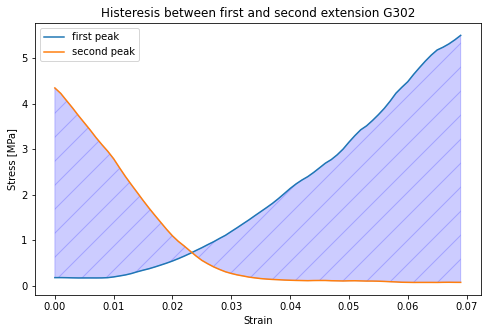

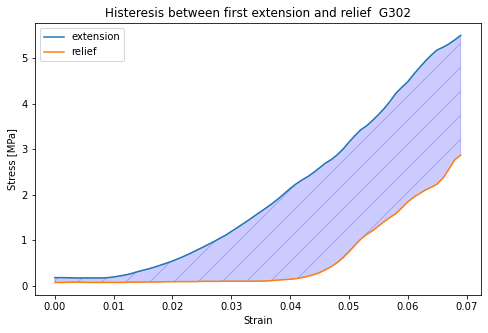

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G303/
[441, 12604, 12424]


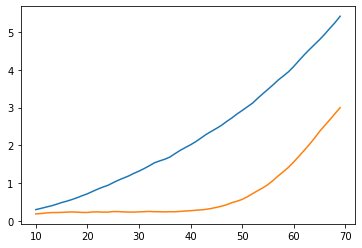

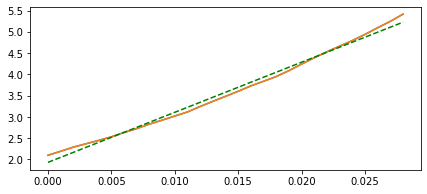

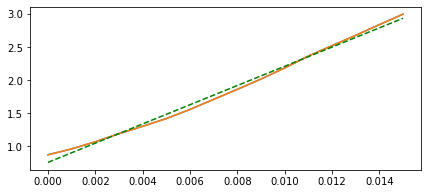

         G303
0  117.760264
1  145.092027
2    0.759526
3         NaN
4    0.683241
5   53.380798
6  123.209666
7   31.000000
8   44.000000
9   70.454545


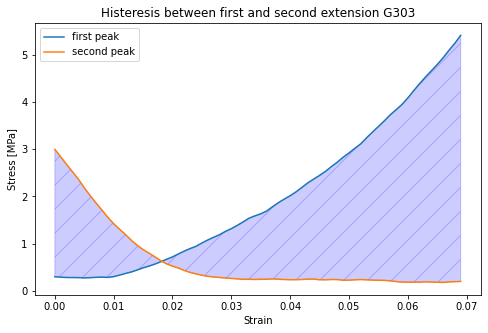

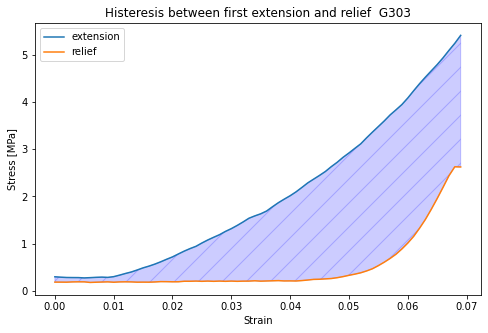

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G304/
[456, 12619, 12439]


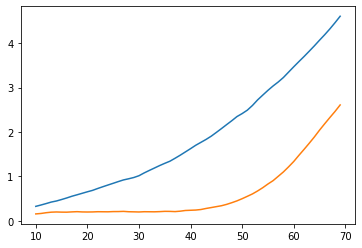

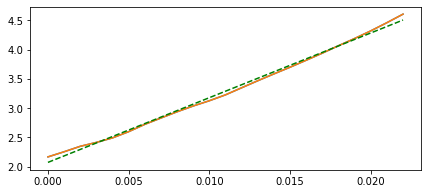

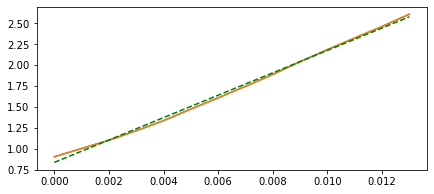

         G304
0  110.614683
1  133.942053
2    0.741705
3         NaN
4    0.676057
5   48.205881
6  121.088855
7   37.000000
8   46.000000
9   80.434783


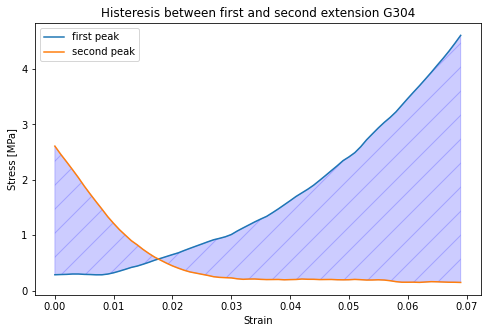

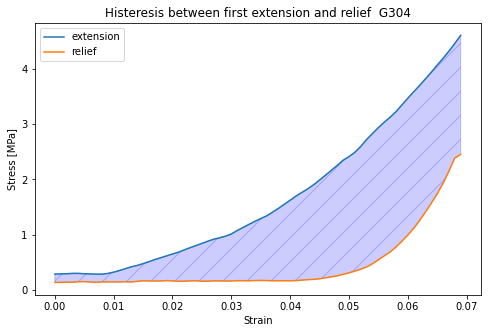

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G305/
próbka: G305  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G306/
[529, 12693, 12513]


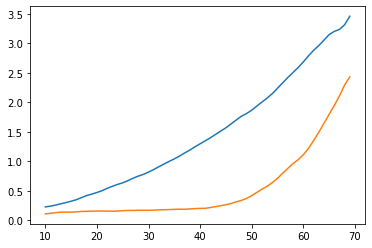

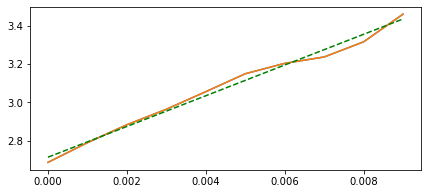

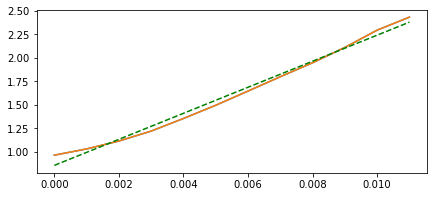

         G306
0   80.150331
1  138.728891
2    0.768183
3         NaN
4    0.641814
5   50.196364
6  173.085861
7   50.000000
8   48.000000
9  104.166667


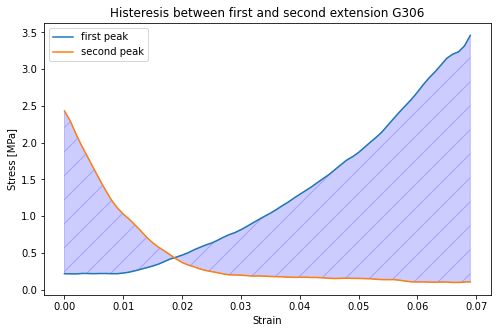

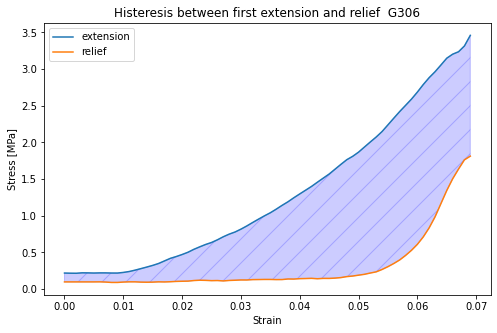

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G307/
[419, 12582, 12402]


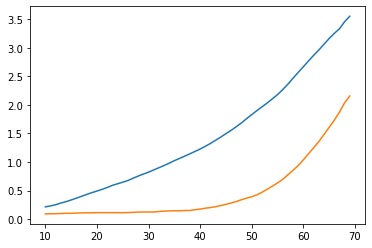

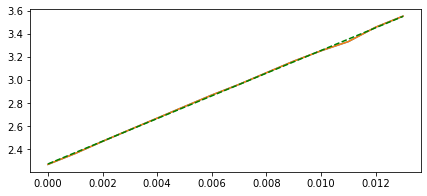

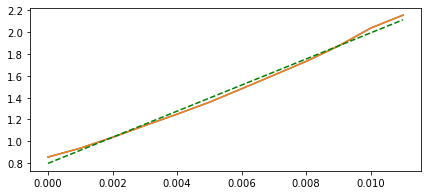

         G307
0   98.303675
1  119.517438
2    0.804612
3         NaN
4    0.680897
5   57.463613
6  121.579826
7   46.000000
8   48.000000
9   95.833333


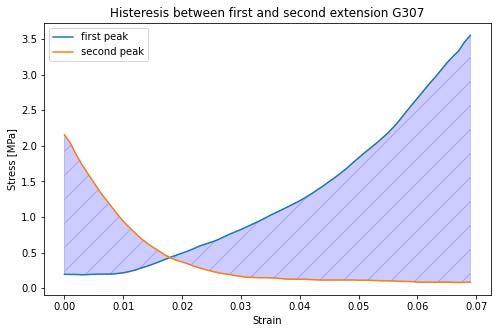

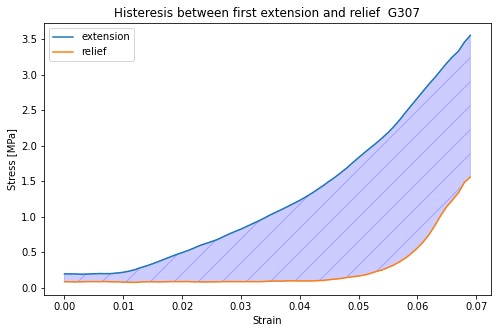

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G308/
[480, 12644, 12464]


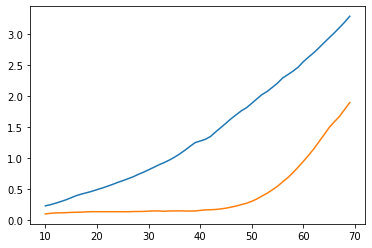

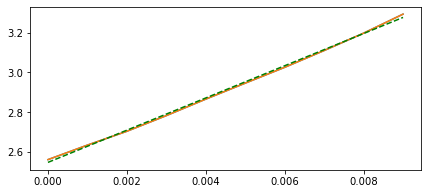

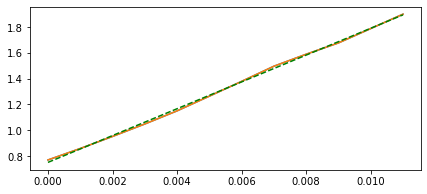

         G308
0   81.158391
1  103.994009
2    0.814227
3         NaN
4    0.701773
5   56.043302
6  128.137101
7   50.000000
8   48.000000
9  104.166667


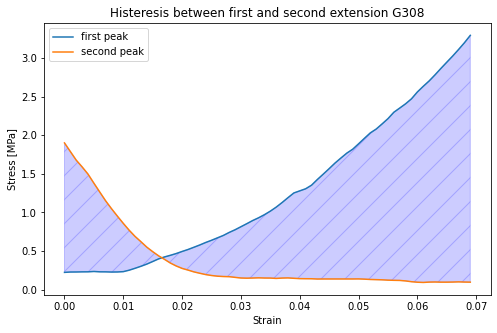

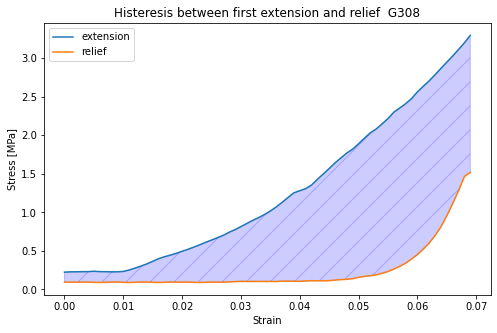

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G309/
[419, 12582, 12402]


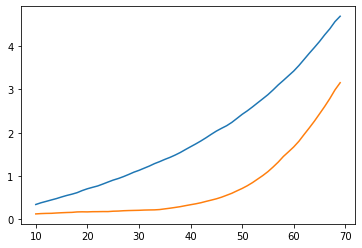

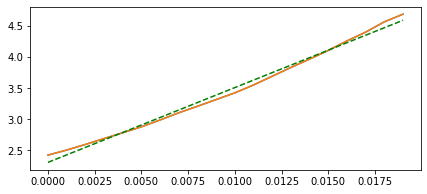

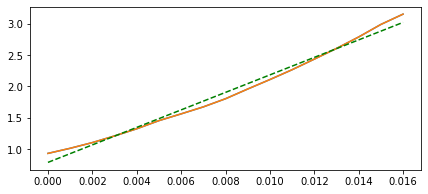

         G309
0  120.027115
1  139.621067
2    0.739684
3         NaN
4    0.615616
5   46.090343
6  116.324605
7   40.000000
8   43.000000
9   93.023256


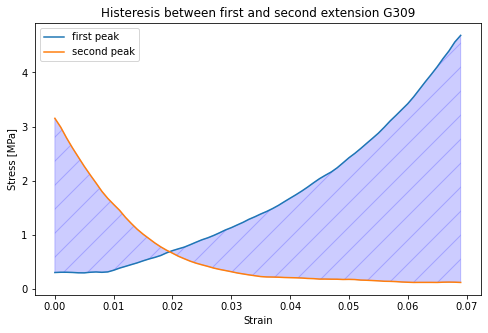

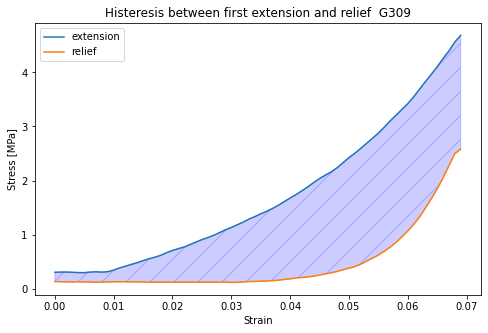

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G310/
[480, 12643, 12463]


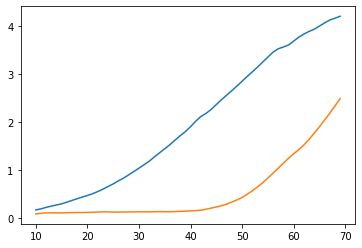

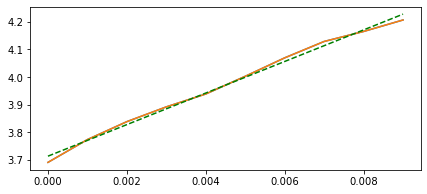

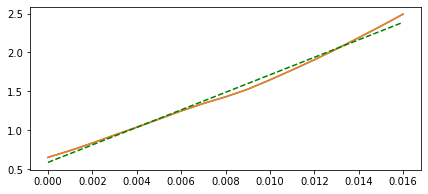

         G310
0   57.270719
1  112.516993
2    0.817565
3         NaN
4    0.728015
5   60.889894
6  196.465131
7   50.000000
8   43.000000
9  116.279070


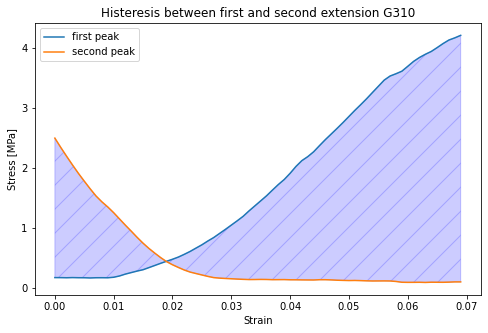

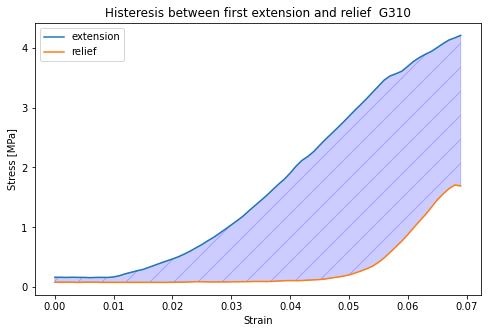

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G311/
próbka: G311  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G312/
próbka: G312  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G401/
[491, 12655, 12475]


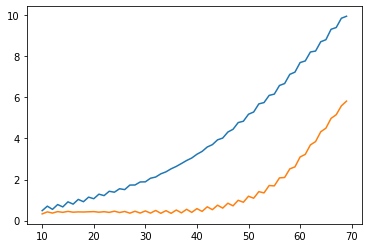

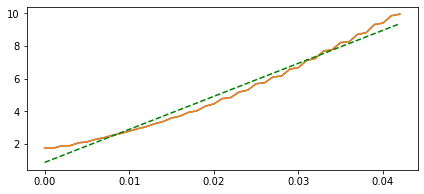

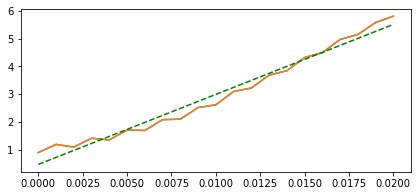

         G401
0  202.154614
1  252.469087
2    0.739110
3         NaN
4    0.654249
5   52.879474
6  124.889105
7   17.000000
8   39.000000
9   43.589744


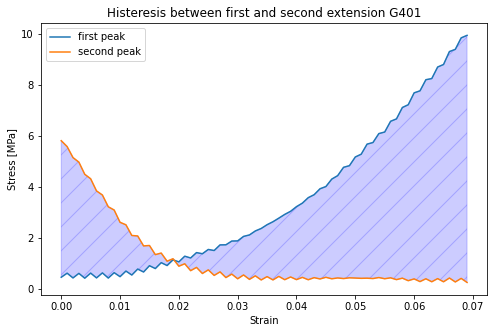

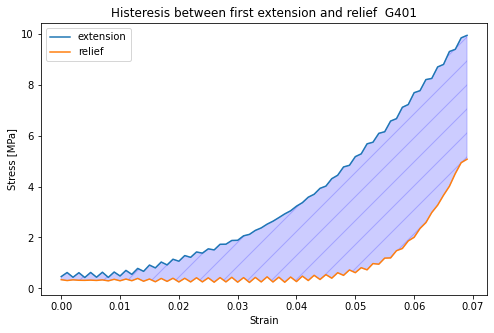

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G402/
[504, 12669, 12489]


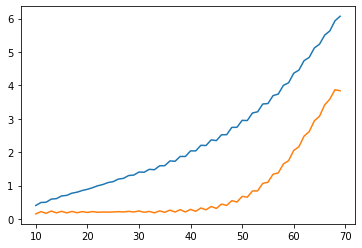

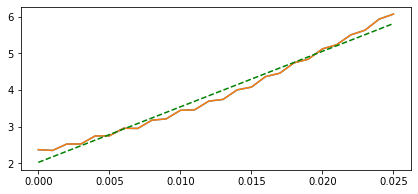

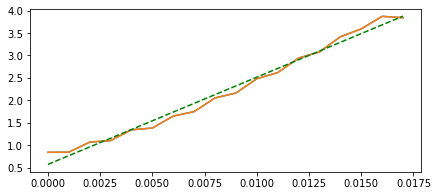

         G402
0  151.666452
1  194.412348
2    0.802574
3         NaN
4    0.646088
5   54.531457
6  128.184147
7   34.000000
8   42.000000
9   80.952381


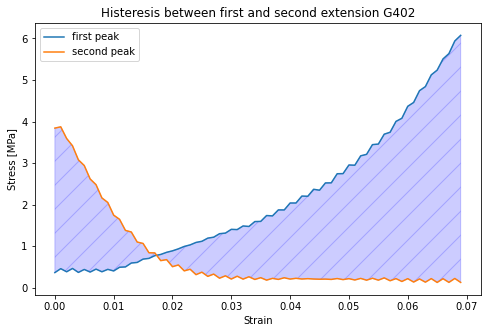

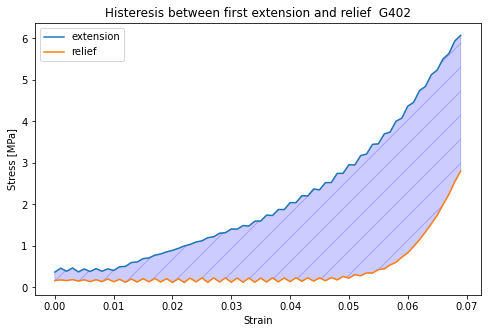

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G403/
[369, 12532, 12352]


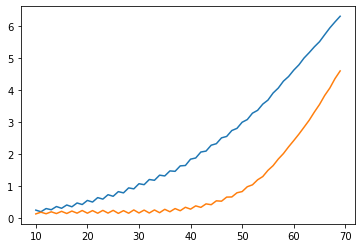

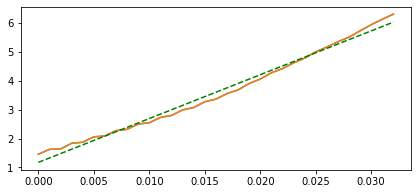

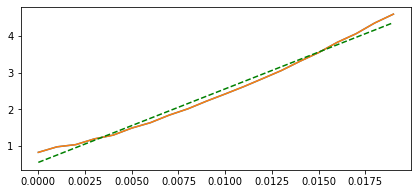

         G403
0  151.550669
1  200.541010
2    0.692703
3    0.662225
4    0.567235
5   46.411901
6  132.326048
7   27.000000
8   40.000000
9   67.500000


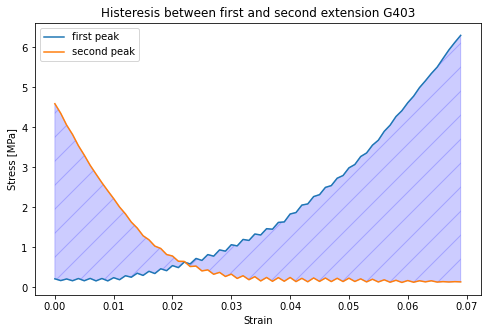

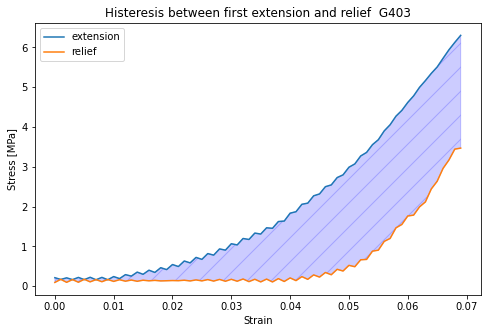

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G404/
[430, 12594, 12414]


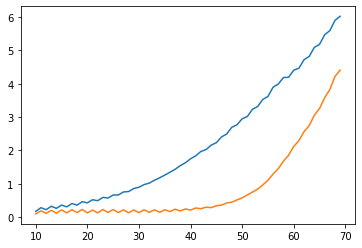

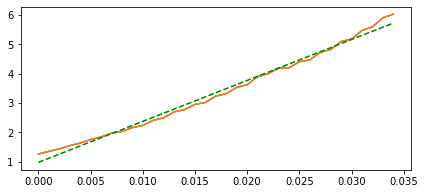

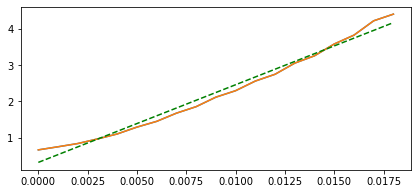

         G404
0  139.789844
1  214.218266
2    0.709131
3         NaN
4    0.610780
5   48.949094
6  153.243082
7   25.000000
8   41.000000
9   60.975610


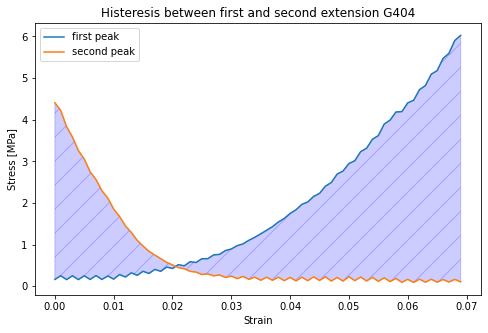

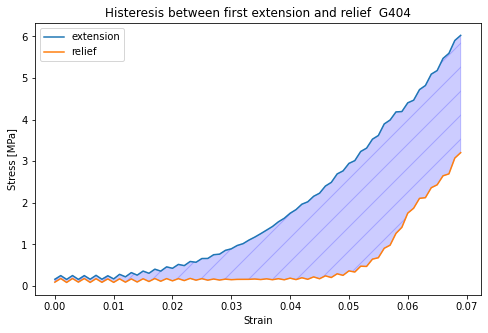

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G405/
[480, 12644, 12464]


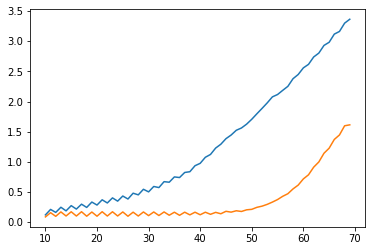

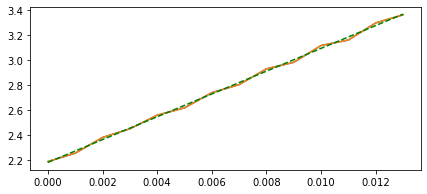

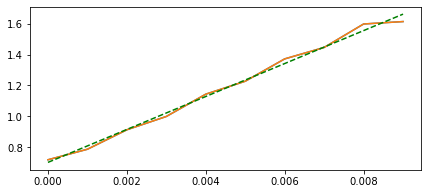

         G405
0   91.650674
1  106.830599
2    0.825886
3         NaN
4    0.718539
5   64.663918
6  116.562807
7   46.000000
8   50.000000
9   92.000000


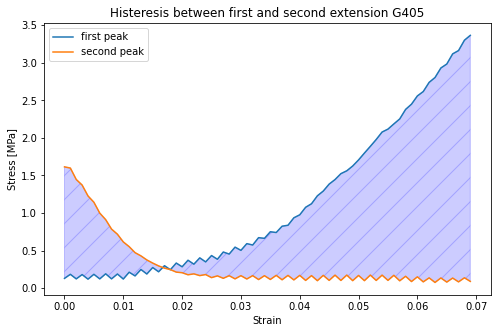

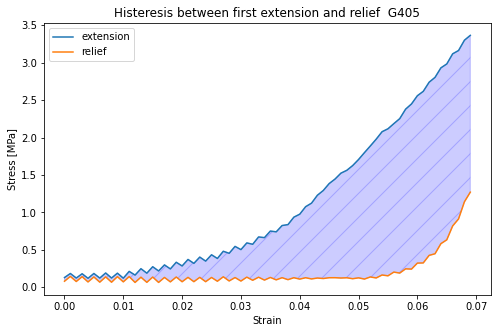

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G406/
próbka: G406  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G407/
próbka: G407  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G408/
próbka: G408  jest uszkodzona/odrzucona etc...
D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G409/
[368, 12533, 12353]


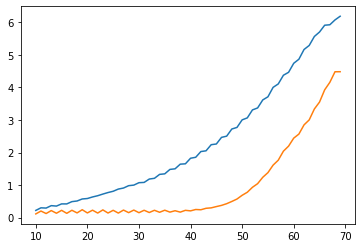

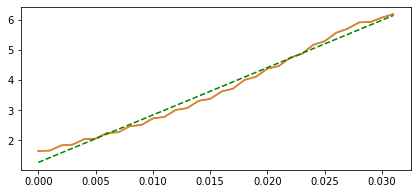

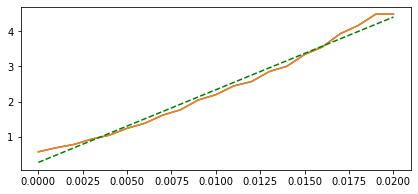

         G409
0  157.500540
1  206.475034
2    0.778583
3    0.755945
4    0.594911
5   52.633856
6  131.094810
7   28.000000
8   39.000000
9   71.794872


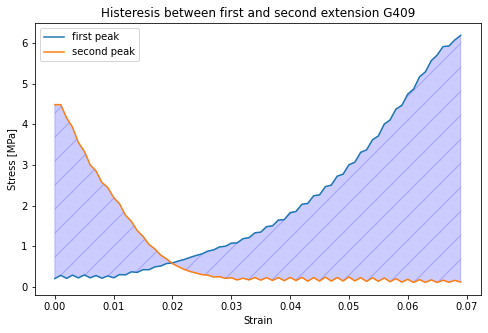

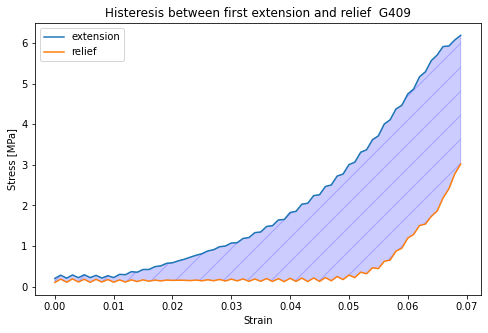

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G410/
[456, 12619, 12439]


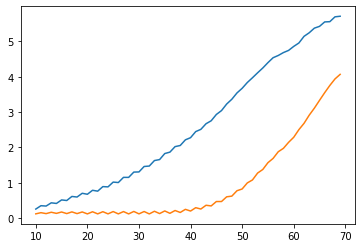

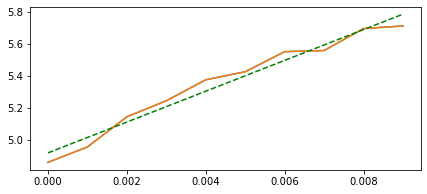

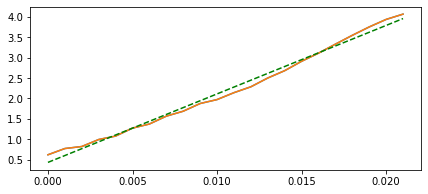

         G410
0   96.461238
1  167.869350
2    0.770409
3         NaN
4    0.647629
5   49.904114
6  174.027778
7   50.000000
8   38.000000
9  131.578947


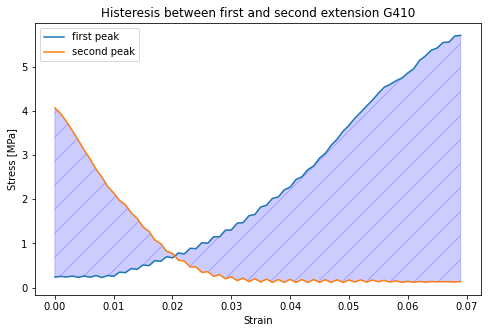

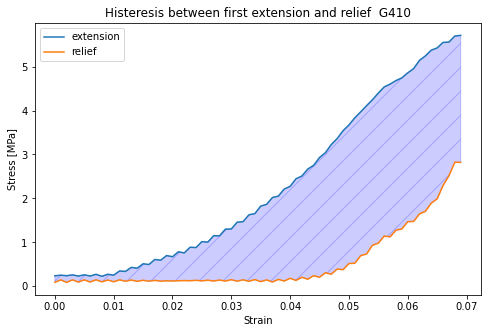

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G411/
[442, 12605, 12425]


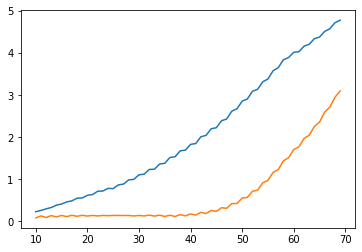

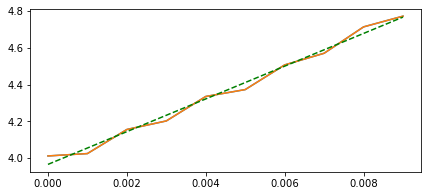

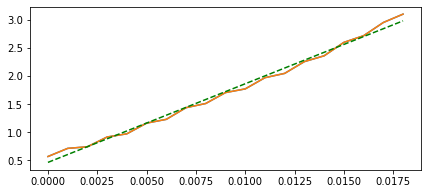

         G411
0   88.957644
1  139.435430
2    0.780886
3         NaN
4    0.684785
5   54.648847
6  156.743619
7   50.000000
8   41.000000
9  121.951220


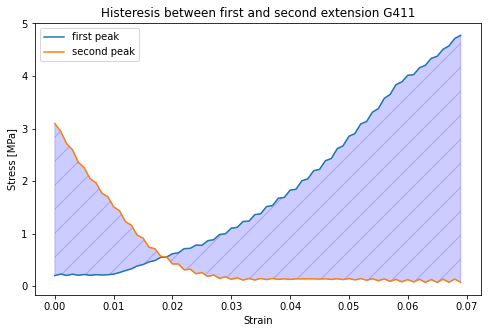

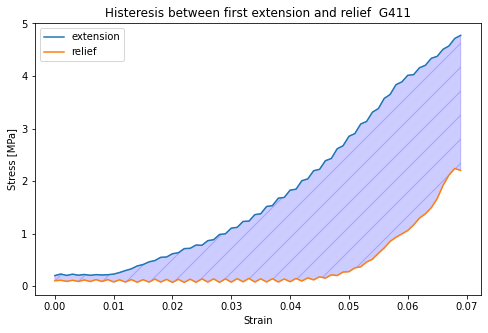

D:/OneDrive/PHD/Badania - zywotnosc komorek napiecie sprezystosc/1-ax-station_control/logs/G412/
próbka: G412  jest uszkodzona/odrzucona etc...
{1:                0           1         2   3         4          5           6  \
G112  100.181579  130.172456  0.731312 NaN  0.540828  45.564865  129.936520   
G111   82.691194  134.044123  0.831603 NaN  0.695856  57.232191  162.102054   
G110   84.818687  103.393028  0.706741 NaN  0.545800  47.662602  121.898879   
G109   57.979718   77.888608  0.698249 NaN  0.534836  47.795153  134.337680   
G108  129.739895  148.716859  0.687571 NaN  0.541283  43.938734  114.626930   
G106  108.652849  135.100993  0.723611 NaN  0.597787  50.246596  124.341879   
G103   84.244226  111.603834  0.796784 NaN  0.675975  51.504580  132.476537   
G102  101.060493  122.543485  0.794887 NaN  0.684702  56.940517  121.257558   
G101   82.446558  111.051566  0.706842 NaN  0.589200  39.448713  134.695213   

         7     8           9  
G112  41.0  41.0  100.000000  

In [6]:

d =  {j: dataProcessing(j) for j in numberOfGroup}
print(d)
#dfData = pd.DataFrame.from_dict(d, orient="index")
#print(dfData)

In [7]:
#print(dfData) col_one_list = df['one'].tolist()
#dfData.iloc[:, dfData.columns.get_level_values(0)=='1'] 
#print(d)
l=list(d.values())

def returnDfOfGroups(l,parametr):
    newDF=pd.DataFrame({'A' : []})
    j=0
    for i in numberOfGroup:  
        newDF=pd.concat([newDF.reindex(newDF.index), pd.DataFrame(l[j][parametr].tolist(), columns=['G'+str(i)])], axis=1)
        j=j+1
    newDF.drop('A', inplace=True, axis=1)
    return newDF


parameters={'Young_1':0,'Young_2':1,'AreaOfHis_1':2,'AreaOfHis_2':3,
            'AreaOfHis_pseudo':4,'DropOfStress':5,'DropOfYoung':6,
            'InflectionPoint_1':7,'InflectionPoint_2':8,'InflectionPointDrop':9}

#print(returnDfOfGroups(l,parameters['Young_1']))

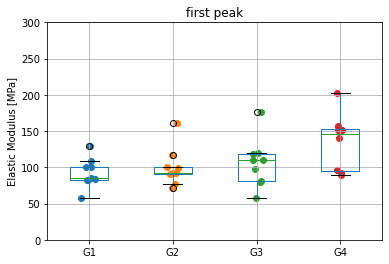

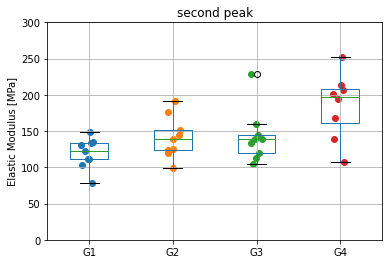

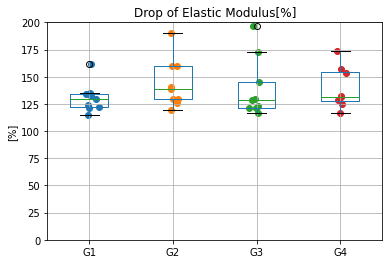

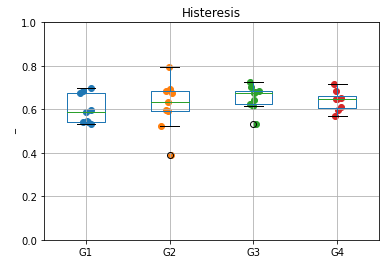

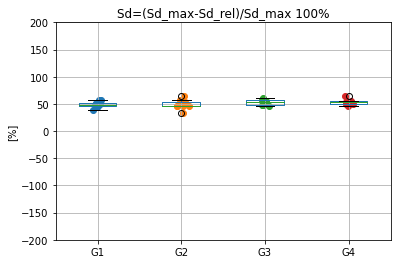

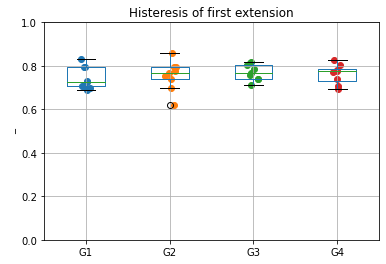

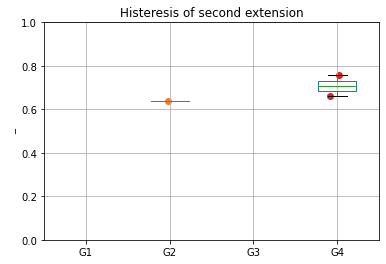

"\nploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_1']),'InflectionPoint_1','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)\n\nploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_2']),'InflectionPoint_2','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)\n\nploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPointDrop']),'InflectionPointDrop','[mm]','Drop of Stress Deriative',0,200)\n#"

In [8]:
ploting=Ploting()
# box_scatter_plot(df,ylabel,               title,     ylim)    
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_1']),'Young_1','Elastic Modulus [MPa]','first peak',0,300)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['Young_2']),'Young_2','Elastic Modulus [MPa]','second peak',0,300)
                 
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung','[%]','Drop of Elastic Modulus[%]',0,200)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo','_','Histeresis',0,1)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress','[%]','Sd=(Sd_max-Sd_rel)/Sd_max 100%',-200,200)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1','_','Histeresis of first extension',0,1)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['AreaOfHis_2']),'AreaOfHis_2','_','Histeresis of second extension',0,1)
'''
ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_1']),'InflectionPoint_1','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPoint_2']),'InflectionPoint_2','[mm]','The strain for which the derivative of the stress becomes stabilized',0,60)

ploting.plot_boxScatterdf(returnDfOfGroups(l,parameters['InflectionPointDrop']),'InflectionPointDrop','[mm]','Drop of Stress Deriative',0,200)
#'''

first peak
pvalue = 0.04271409980843237 F=3.059737949580366

p<0.05

Anderson bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.250000  0.250000  0.015217
G2  0.250000  1.000000  0.250000  0.204278
G3  0.250000  0.250000  1.000000  0.188273
G4  0.015217  0.204278  0.188273  1.000000
Ttest bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.492677  0.325569  0.012705
G2  0.492677  1.000000  0.707580  0.048981
G3  0.325569  0.707580  1.000000  0.120258
G4  0.012705  0.048981  0.120258  1.000000
Ttest z poprawką Bonferroniego
          G1        G2        G3        G4
G1  1.000000  1.000000  1.000000  0.076231
G2  1.000000  1.000000  1.000000  0.293887
G3  1.000000  1.000000  1.000000  0.721545
G4  0.076231  0.293887  0.721545  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


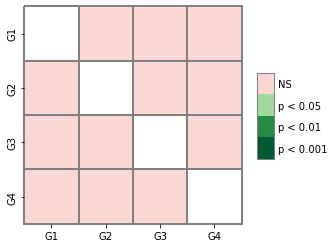

second peak
pvalue = 0.0037065370517100145 F=5.523909556268638

p<0.05

Anderson bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.159452  0.171003  0.004207
G2  0.159452  1.000000  0.250000  0.028187
G3  0.171003  0.250000  1.000000  0.072803
G4  0.004207  0.028187  0.072803  1.000000
Ttest bez poprawki Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.083250  0.122013  0.001452
G2  0.083250  1.000000  0.950219  0.030087
G3  0.122013  0.950219  1.000000  0.048590
G4  0.001452  0.030087  0.048590  1.000000
Ttest z poprawką Bonferroniego
          G1        G2        G3        G4
G1  1.000000  0.499499  0.732077  0.008713
G2  0.499499  1.000000  1.000000  0.180524
G3  0.732077  1.000000  1.000000  0.291540
G4  0.008713  0.180524  0.291540  1.000000


D:\Anaconda3\lib\site-packages\scikit_posthocs\_posthocs.py:1214: UserWarning: p-value capped: true value larger than 0.25
  vs[i, j] = ss.anderson_ksamp([x.loc[x[_group_col] == groups[i], _val_col], x.loc[x[_group_col] == groups[j], _val_col]], midrank=midrank)[2]


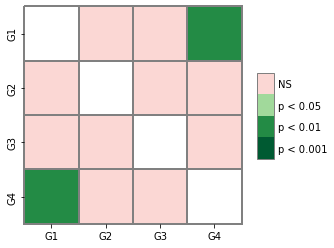

Drop off stress
pvalue = 0.3578343187465619 F=1.1153722042703413

niby histereza
pvalue = 0.5075290740573343 F=0.7922113446374153

spadek Modulow
pvalue = 0.6230948693204326 F=0.594883559504066

His 1
pvalue = 0.6835628917008285 F=0.5021820060345371

His 2


"\nprint('InflectionPoint_1')\nStaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_1']))\nprint('InflectionPoint_2')\nStaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_2']))\nprint('InflectionPointDrop')\nStaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPointDrop']))\n"

In [9]:
print('first peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_1']),'Young_1')
print('second peak')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['Young_2']),'Young_2')
print('Drop off stress')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfStress']),'DropOfStress')
print('niby histereza')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_pseudo']),'AreaOfHis_pseudo')
print('spadek Modulow')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['DropOfYoung']),'DropOfYoung')
print('His 1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_1']),'AreaOfHis_1')
print('His 2')
#StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['AreaOfHis_2']))

'''
print('InflectionPoint_1')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_1']))
print('InflectionPoint_2')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPoint_2']))
print('InflectionPointDrop')
StaticCalculus.annovaTest(returnDfOfGroups(l,parameters['InflectionPointDrop']))
'''